In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
label_sup = []
label_un = []

In [ ]:
import fnmatch
train = []
tes = []
val = []
train_un = []
test_un = []
val_un = []

for root,dirs,files in os.walk('./3fold_out4/train'):
    if files:
        lst = os.listdir(root)
        png = fnmatch.filter(lst,'*.png')
        if png:
            for i in png:
                train.append((root+'/'+i, int(i[3])-1))
                

for root,dirs,files in os.walk('./3fold_out4/test'):
      if files:
        lst = os.listdir(root)
        png = fnmatch.filter(lst,'*.png')
        if png:
            for i in png:
                tes.append((root+'/'+i, int(i[3])-1))
for root,dirs,files in os.walk('./3fold_out4/val'):
      if files:
        lst = os.listdir(root)
        png = fnmatch.filter(lst,'*.png')
        if png:
            for i in png:
                val.append((root+'/'+i, int(i[3])-1))
                
#train.append((root+'/'+i, label_sup.index(i[3:6])))    

In [ ]:
trn = train + val
test = tes

In [ ]:
train_un = []
for i in trn:
    if i[0].split('/')[-1][3:6] not in label_un:
        label_un.append(i[0].split('/')[-1][3:6])
        label_sup.append(i[1])
    train_un.append((i[0],label_un.index(i[0].split('/')[-1][3:6])))

In [ ]:
class_num = len(label_un)

In [ ]:
class_num

In [8]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import matplotlib.pyplot as plt

In [9]:
trn = train_un
test = test

In [10]:
class MyDataset(Dataset):
    def __init__(self, image_path, transform = None):
        self.image_list = image_path
        self.len = len(self.image_list)
        self.transform = transform
    def __getitem__(self, index):
        fn, label = self.image_list[index]
        img = Image.open(fn)
        label = np.array(label,dtype = np.float64)
        if self.transform is not None:
            img = self.transform(img) 
        return img, label
    def __len__(self):
        return self.len

Transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.CenterCrop(224),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])
Lable_trasfrom = transforms.Compose([
    transforms.ToTensor()
    ])

In [11]:
train_data = MyDataset(trn, transform = Transform)
test_data = MyDataset(test, transform = Transform)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

In [12]:
import torchvision.models as models
from torch import nn,optim

In [13]:
class EmbeddingNet(torch.nn.Module):
    def __init__(self, embedding_size=128):
        super(EmbeddingNet, self).__init__()
        self.densenet = models.resnet18(pretrained=True)
        self.densenet.fc = torch.nn.Sequential(
            torch.nn.Linear(512,embedding_size),
            #torch.nn.ReLU(),
            #torch.nn.Dropout(0.6),
            #torch.nn.Linear(256,embedding_size)
        )
        
    def forward(self, x):
        embedding = self.densenet(x)
        norm = embedding.norm(p=2, dim=1, keepdim=True)
        embedding = embedding.div(norm)
        return embedding
    
    def get_embedding(self, x):
        return self.forward(x)

In [14]:
net = EmbeddingNet()

class class_net(torch.nn.Module):
    def __init__(self, embedding_net):
        super(class_net, self).__init__()
        self.net = embedding_net
        self.classes =  nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(128,class_num),
            torch.nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        embedding = self.net(x)
        labels = self.classes(embedding)
        return labels
    
    def get_embedding(self, x):
        return self.forward(x)
    
my_resnet = class_net(net)

In [15]:
'''my_resnet.classifier = nn.Sequential(
    nn.Linear(1024, 128),
    nn.ReLU(),
    #nn.Dropout(0.6),
    nn.Linear(128,65),
    nn.LogSoftmax(dim=1)
)'''

'''my_resnet.classifier = nn.Sequential(
    nn.Linear(1024, 128),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(128,5),
    nn.LogSoftmax(dim=1)
)'''

'my_resnet.classifier = nn.Sequential(\n    nn.Linear(1024, 128),\n    nn.ReLU(),\n    nn.Dropout(0.6),\n    nn.Linear(128,5),\n    nn.LogSoftmax(dim=1)\n)'

In [16]:
my_resnet = my_resnet.to('cuda:0')

In [17]:
#loss_func = FocalLoss()
#loss_func = NPairLoss()
loss_func = nn.NLLLoss()
lr = 1e-2
#optimizer = optim.Adam(my_resnet.parameters(), lr=lr)
#optimizer = optim.Adam(my_resnet.parameters(), lr=lr)
optimizer = optim.SGD(my_resnet.parameters(),
                                lr=lr,
                                momentum=0.9,
                                weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=400, gamma=0.1, last_epoch=-1)

In [18]:
import time

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
history = []
best_acc = 0.0
best_epoch = 0
best_each = ''

best_loss = 100.0

In [20]:
for epoch in range(500):
    epoch_start = time.time()
    print("Epoch: {}/{}".format(epoch+1, 500))
    my_resnet.train()
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
    for i,(data,label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        label = label.long()
        optimizer.zero_grad()
        outputs = my_resnet(data)
        loss = loss_func(outputs,label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(label.data.view_as(predictions))
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        train_acc += acc.item() * data.size(0)
    with torch.no_grad():
        my_resnet.eval()
        #correct = list(0. for i in range(5))
        #total = list(0. for i in range(5))
        #correct = list(0. for i in range(2))
        #total = list(0. for i in range(2))
        for j, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.long()

            outputs = my_resnet(inputs)

            #loss = loss_func(outputs, labels)
            #valid_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            for label_idx in range(len(labels)):
                predictions[label_idx] = label_sup[predictions[label_idx]]
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            valid_acc += acc.item() * inputs.size(0)
            res = predictions == labels
            '''for label_idx in range(len(labels)):
                label_single = labels[label_idx]
                correct[label_single] += res[label_idx].item()
                total[label_single] += 1'''

    scheduler.step()
    avg_train_loss = train_loss/len(trn)
    avg_train_acc = train_acc/len(trn)

    avg_valid_loss = valid_loss/len(test)
    avg_valid_acc = valid_acc/len(test)

    #acc_str = 'Accuracy: %f'%(sum(correct)/sum(total))

    '''for acc_idx in range(5):
    #for acc_idx in range(2):
        try:
            acc = correct[acc_idx]/total[acc_idx]
        except:
            acc = 0
        finally:
            acc_str += ' classID:%d acc:%f '%(acc_idx+1, acc)'''

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
    if best_acc <= avg_valid_acc:
        best_acc = avg_valid_acc
        best_epoch = epoch + 1
        torch.save(my_resnet.state_dict(),'./weight/bestloss_un_test_56.pth')

    epoch_end = time.time()

    print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
    print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
    torch.save(my_resnet.state_dict(),'./weight/lastloss_test_56.pth')
    #print(acc_str)#print("Best Acc's each class acc:",best_each)
print("Best Acc's each class acc:",best_each)

Epoch: 1/500
Epoch: 001, Training: Loss: 4.0269, Accuracy: 1.8237%, 
		Validation: Loss: 0.0000, Accuracy: 25.0000%, Time: 1.0471s
Best Accuracy for validation : 0.2500 at epoch 001
Epoch: 2/500
Epoch: 002, Training: Loss: 4.0046, Accuracy: 5.1672%, 
		Validation: Loss: 0.0000, Accuracy: 38.7500%, Time: 0.8297s
Best Accuracy for validation : 0.3875 at epoch 002
Epoch: 3/500
Epoch: 003, Training: Loss: 3.9836, Accuracy: 5.1672%, 
		Validation: Loss: 0.0000, Accuracy: 42.5000%, Time: 0.8009s
Best Accuracy for validation : 0.4250 at epoch 003
Epoch: 4/500
Epoch: 004, Training: Loss: 3.9581, Accuracy: 5.7751%, 
		Validation: Loss: 0.0000, Accuracy: 42.5000%, Time: 0.8050s
Best Accuracy for validation : 0.4250 at epoch 004
Epoch: 5/500
Epoch: 005, Training: Loss: 3.9351, Accuracy: 6.6869%, 
		Validation: Loss: 0.0000, Accuracy: 42.5000%, Time: 0.8124s
Best Accuracy for validation : 0.4250 at epoch 005
Epoch: 6/500
Epoch: 006, Training: Loss: 3.9099, Accuracy: 6.9909%, 
		Validation: Loss: 0

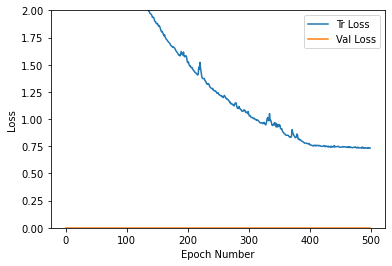

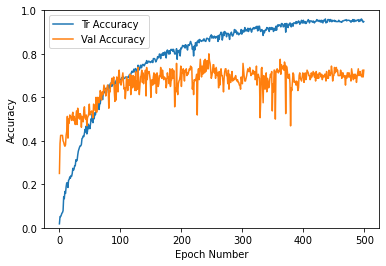

In [21]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()
